# Project 2 - COSC 528
## October 22, 2018
## Author: Ian R. Stewart

In [1]:
import pandas as pd
import numpy as np
import itertools
import tabulate # New library for plotting tables (similar to pprint)
import math, random, copy
import sys
import warnings
warnings.filterwarnings("ignore")

# importing SVD library to extract PCs
from scipy.linalg import svd

# plotting libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Importing Data

In [2]:
df = pd.read_excel('UTK-peers.xlsx')

Searching for empty rows and making University Name the dataframe index.

In [3]:
first_row_with_all_NaN = df.shape[0]-df[df.isnull().all(axis=1) == True].shape[0]
df = df.loc[0:first_row_with_all_NaN-1]
df = df.set_index(df['Name'])
df.head()

,Name,IPEDS#,Carm R1,HBC,% Blk Total Students,% Hisp Total Students,2017 US News top 65,2014 Med School,Vet School,Total Enroll,...,ACT/ SAT 25%,ACT/ SAT 75%,(State/ Tuit)/ St. FTE,Med School Res $,Academic Support Expenditures,Student Services Expenditures,Endowment Figure,Endowment per Student FTE,Total Faculty.1,Total Tenure /Tenure-Track Facutly.1
Name,,,,,,,,,,,,,,,,,,,,,
Univ. of Tennessee - Knoxville,Univ. of Tennessee - Knoxville,221759.0,1.0,No,6.625965,3.404561,46.0,NaN,x,27845.0,...,24.0,30.0,22093.596931,0.0,7.827344e+08,30587.112868,7.827344e+08,30587.112868,1526.0,1117.0
Univ. of Georgia,Univ. of Georgia,139959.0,1.0,No,8.048713,4.732909,18.0,NaN,x,36130.0,...,25.0,30.0,23743.789087,0.0,9.390242e+08,27830.636107,9.390242e+08,27830.636107,1918.0,1606.0
Purdue Univ.,Purdue Univ.,243780.0,1.0,No,2.994663,4.128780,20.0,NaN,x,40472.0,...,23.0,30.0,25230.954999,0.0,2.445542e+09,66375.581533,2.445542e+09,66375.581533,1783.0,1700.0
Texas A&M Univ.,Texas A&M Univ.,228723.0,1.0,No,3.203109,19.193581,27.0,pre clin,x,63813.0,...,23.0,29.0,29423.418111,52058.0,1.052103e+10,180613.450122,1.052103e+10,180613.450122,2983.0,1995.0
Michigan State Univ.,Michigan State Univ.,171100.0,1.0,No,6.591080,4.020737,33.0,x,x,50538.0,...,23.0,28.0,22975.311112,52594.0,2.549137e+09,55180.107179,2.549137e+09,55180.107179,2616.0,1811.0


Dropping unique features from dataframe and large amounts of missing values.

In [4]:
df = df.drop(['IPEDS#','HBC','Carm R1','Med School Res $','AG Research ($000)','Med School Res $','Academic Support Expenditures','Profess Degrees'],axis=1)
df = df.drop(df.columns[-1], axis=1);df = df.drop(df.columns[-1], axis=1) # Dropping final two columns; they are repeats
df.shape

(57, 56)

Dropping indexs where multiple missing values within remaining data features.

In [5]:
df = df.drop(['Univ. of Pittsburgh ','Delaware','Univ. of Colorado '],axis=0)
df.shape

(54, 56)

Searching for features with missing or null values.

In [6]:
count = 0; indexes = []
for i in df.isnull().any():
    if i == True:
        indexes.append(count)
    count+=1
print df.columns.values[indexes]

[u'2014 Med School' u'Vet School' u'Endowment' u'Wall St. Jourl Rank'
 u'Enowment / St. FTE']


Inserting correct WSJ College Rankings from following reference: https://www.timeshighereducation.com/sites/default/files/breaking_news_files/wsj-the-college-rankings-2017-results.pdf

University with partial names, such 'Utah', were confirmed to be specific universities via the IPEDS number.

In [7]:
df['Wall St. Jourl Rank'][df['Name']=='Delaware']=137
df['Wall St. Jourl Rank'][df['Name']=='Colorado State']=353
df['Wall St. Jourl Rank'][df['Name']==' Arizona State']=131
df['Wall St. Jourl Rank'][df['Name']=='Georgia Tech']=51
df['Wall St. Jourl Rank'][df['Name']=='UC-Irvine']=153
df['Wall St. Jourl Rank'][df['Name']=='UC-San Diego']=49
df['Wall St. Jourl Rank'][df['Name']=='Connecticut']=110
df['Wall St. Jourl Rank'][df['Name']==' Iowa']=164
df['Wall St. Jourl Rank'][df['Name']=='Buffalo']=130
df['Wall St. Jourl Rank'][df['Name']=='Utah']=311
df['Wall St. Jourl Rank'][df['Name']=='UC-Riverside']=368
df['Wall St. Jourl Rank'][df['Name']==' Arizona']=162

In [8]:
df['2014 Med School'][df['2014 Med School']=='x']=1
df['2014 Med School'][df['2014 Med School']=='pre clin']=1
df['2014 Med School'][df['2014 Med School']!=int(1)]=0
df['Vet School'][df['Vet School']!='x']=0
df['Vet School'][df['Vet School']=='x']=1
df['Endowment'][df['Name']=='Clemson Univ.']=621.3E6

In [9]:
count = 0; indexes = []
for i in df.isnull().any():
    if i == True:
        indexes.append(count)
    count+=1
print 'Feautures with missing data: %s'%df.columns.values[indexes]

Feautures with missing data: [u'Enowment / St. FTE']


Error in feature label. Fixing typo of label "Enowment / St. FTE" to "Endowment / St. FTE"

In [10]:
df.rename(columns={"Enowment / St. FTE":"Endowment / St. FTE"},inplace=True)

Fixing NaN value in Endowment / St. FTE ; It should be noted that after checking the other values for this feature, the Endowment divided by St. FTE is *NOT* exactly the reported value in the provided data.

In [11]:
count = 0
for i in df["Endowment / St. FTE"]:
    j = str(i)
    if j == "nan":
        name = df['Name'][count]
        endowment = df['Endowment'][df['Name']==name]
        fte = df['ST. FTE'][df['Name']==name]
        df["Endowment / St. FTE"][df['Name']==name]=int(endowment / fte)
    count+=1

Re-verifying that all features have are filled with no missing data.

In [12]:
count = 0; indexes = []
for i in df.isnull().any():
    if i == True:
        indexes.append(count)
    count+=1
print 'Feautures with missing data: %s'%df.columns.values[indexes]

Feautures with missing data: []


Fixing data types on manipulated data feautures.

In [13]:
df['Name']=df['Name'].astype('|S')
df['Vet School']=df['Vet School'].astype(float)
df['2014 Med School']=df['2014 Med School'].astype(float)

Now that the data has been explored with appropriate handling of the unique features and missing data, let's create a data matrix containing soley the numeric attributes for analysis.

In [14]:
analysis = df.iloc[:,1::] # Essentially, we are only dropping the university name

In [15]:
analysis.shape

(54, 55)

Performed z-Standardization while mean-centering the data prior to analysis.

In [16]:
# Centering each data feature
a_standardized=(analysis.iloc[:,0::]-analysis.iloc[:,0::].mean())/analysis.iloc[:,0::].std()

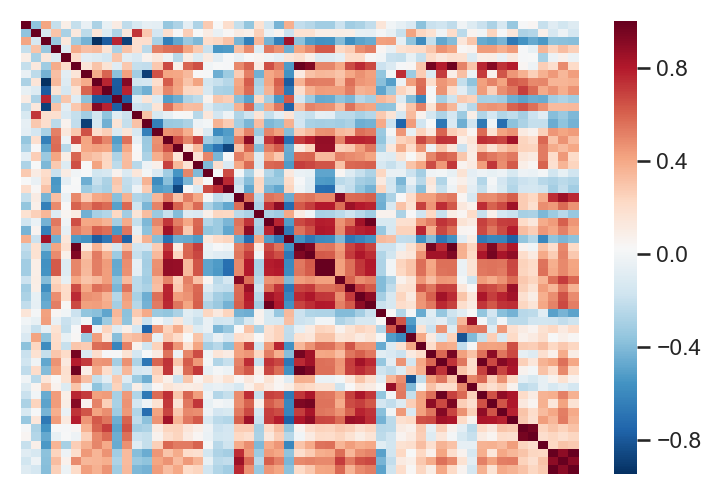

In [17]:
# Exploring correlation matrix
cols = list(a_standardized.columns.values)
corr = np.corrcoef(a_standardized.values.T)
plt.figure(dpi=150)
sns.set(font_scale=1.0)
sns.heatmap(corr,cbar=True,cmap="RdBu_r",yticklabels=[],xticklabels=[])
plt.savefig('covariance.png',dpi=600)

### **Analysis**

Finding factorized matrices from created analysis matrix. For the matrix **a_standardized** with (*54x55*), the expected sizes of the factorized matrices are as follows: **U**(*54x54*), **Sigma**(*54x54*), and **VT**(*54x55*). Of note, the package utilized here (SciPy.linalg.SVD) outputs a single column (54-length vector) for **Sigma**, which is actually a diagonal matrix and not a single column vector matrix. These values are known as the singular values of the original matrix **a_standardized**, while **U** and **VT** are referred to as the left-singular and right-singular vectors of **a_standardized**, respectively.

In [18]:
U, Sigma, VT = svd(a_standardized.values,full_matrices=False)
PCs = a_standardized.values.dot(VT.T)

In [19]:
# Verifying shape of SVD from SciPy.linalg.SVD function
U.shape,Sigma.shape,VT.shape

((54, 54), (54,), (54, 55))

Now that the matrix decomposition is complete, we must find the optimal threshold for the number of dimensions to retain. To assist in making this decision, we can create a Scree plot to visualize the data. Of note, the variance is calculated by squaring the singular values (i.e. values in **Sigma** vector).

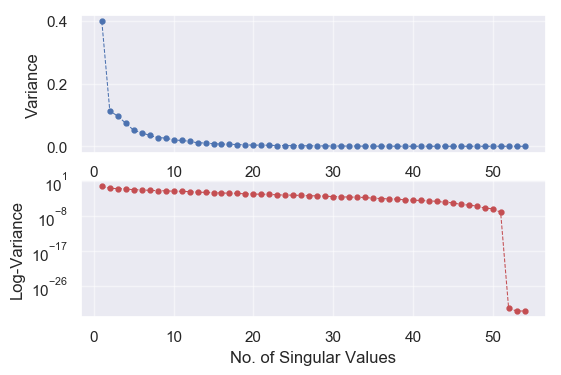

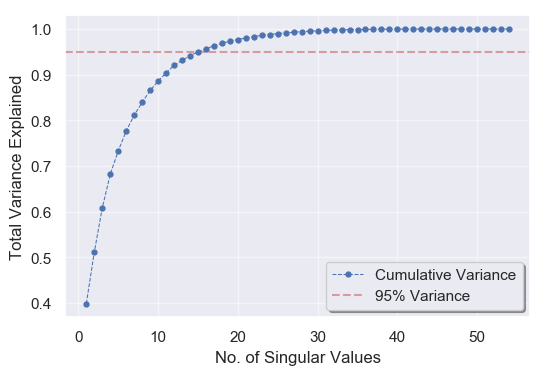

In [20]:
# Calc. Variance for each PC
variance_sigma = Sigma**2/np.sum(Sigma**2)

# Calc. Total Variance Explained for each PC step
PC_no = np.arange(1,len(variance_sigma)+1)
total_variance = []
for i in range(len(variance_sigma)):
    var = variance_sigma[i]
    if i == 0:
        total_variance.append(var)
    else:
        total_variance.append(total_variance[i-1]+var)

fig, (ax,ax1) = plt.subplots(nrows=2,dpi=100)
ax.plot(PC_no,variance_sigma,'o--',markersize=3.5,linewidth=0.75)
ax.grid(alpha=0.5)
ax.set_ylabel('Variance')
ax1.plot(PC_no,variance_sigma,'ro--',markersize=3.5,linewidth=0.75)
ax1.set_ylabel('Log-Variance')
ax1.set_xlabel('No. of Singular Values')
ax1.set_yscale('log')
ax1.grid(which='both',alpha=0.5)
#plt.savefig('/Users/i6o/Research/COSC 528/Project 2/Figures/Variance_Explained_Per_PC.png',format='png',dpi=600)

fig, ax = plt.subplots(dpi=100)
ax.plot(PC_no,total_variance,'o--',markersize=3.5,linewidth=0.75,zorder=2,label='Cumulative Variance')
ax.grid(alpha=0.5)
ax.set_ylabel('Total Variance Explained')
ax.set_xlabel('No. of Singular Values')
plt.axhline(0.95,color='r',linestyle='--',alpha=0.5,zorder=1,label='95% Variance')
plt.legend(loc='best',fancybox=True,shadow=True)
#plt.savefig('/Users/i6o/Research/COSC 528/Project 2/Figures/Total_Variance_Explained.png',format='png',dpi=600)

In [21]:
# Print Variance and Total Variance explained by each Principal Component (PC)
n = 20
print tabulate.tabulate({"P.C.": PC_no[0:n],"Variance Explained":total_variance[0:n],"P.C. Variance": variance_sigma[0:n]}, headers="keys")

  P.C.    P.C. Variance    Variance Explained
------  ---------------  --------------------
     1       0.399029                0.399029
     2       0.112883                0.511912
     3       0.0964152               0.608327
     4       0.073706                0.682033
     5       0.0511675               0.733201
     6       0.0434672               0.776668
     7       0.0346113               0.811279
     8       0.0280249               0.839304
     9       0.0260997               0.865404
    10       0.0201635               0.885567
    11       0.0185845               0.904152
    12       0.0160968               0.920248
    13       0.0109811               0.931229
    14       0.010538                0.941767
    15       0.00798186              0.949749
    16       0.00703425              0.956784
    17       0.00638913              0.963173
    18       0.00560924              0.968782
    19       0.00430158              0.973084
    20       0.00379764           

Comparing results for Explained Variance for Singular Values and Scikit-Learn PCA function (only for ***comparison*** purposes!)

In [22]:
from sklearn.decomposition import PCA
n = 20
pca = PCA(n_components=n)
pca.fit(a_standardized)
print 'PC No.\tSVD Variance\tSVD Cumulative\tPCA Cumulative'
for i in range(0,n):
    if i == 0:
        print "%i\t%.2f %%\t\t%.2f %%\t\t%.2f %%"%(i+1,np.sum(variance_sigma[i])*100,variance_sigma[i]*100,np.sum(pca.explained_variance_ratio_[i]*100))
    else:
        print  "%i\t%.2f %%\t\t%.2f %%\t\t%.2f %%"%(i+1,variance_sigma[i]*100,np.sum(variance_sigma[0:i+1])*100,np.sum(pca.explained_variance_ratio_[0:i+1]*100))

PC No.	SVD Variance	SVD Cumulative	PCA Cumulative
1	39.90 %		39.90 %		39.90 %
2	11.29 %		51.19 %		51.19 %
3	9.64 %		60.83 %		60.83 %
4	7.37 %		68.20 %		68.20 %
5	5.12 %		73.32 %		73.32 %
6	4.35 %		77.67 %		77.67 %
7	3.46 %		81.13 %		81.13 %
8	2.80 %		83.93 %		83.93 %
9	2.61 %		86.54 %		86.54 %
10	2.02 %		88.56 %		88.56 %
11	1.86 %		90.42 %		90.42 %
12	1.61 %		92.02 %		92.02 %
13	1.10 %		93.12 %		93.12 %
14	1.05 %		94.18 %		94.18 %
15	0.80 %		94.97 %		94.97 %
16	0.70 %		95.68 %		95.68 %
17	0.64 %		96.32 %		96.32 %
18	0.56 %		96.88 %		96.88 %
19	0.43 %		97.31 %		97.31 %
20	0.38 %		97.69 %		97.69 %


#### Checking SVD and PCA output on sample setup prior to using on dataset.

In [23]:
a = np.array([[59,64,71,83],[75,80,55,97],[94,64,1,111],[44,36,74,98],[12,85,40,156]]) # Sample Dataset
a = (a-np.mean(a,axis=0))/np.std(a,axis=0) # mean centering
U_test,Sigma_test,VT_test = svd(a,full_matrices=False) # SVD of sample dataset
print '\n'
n = min(a.shape)
# Scikit-Learn PCA fit
pca = PCA(n_components=n)
pca.fit(a)
# SVD created fit
answer = np.array(U_test*Sigma_test)
answer[:,1::]*=-1.
print answer
print'\n'
print pca.transform(a)



[[-1.08561775 -0.4203799   0.6647579   0.16950376]
 [-0.2011199   0.50042299  1.0464904  -0.14757402]
 [ 0.13403235  2.10809331 -0.70075739  0.03332465]
 [-1.4059338  -1.25117431 -0.91095531 -0.07346205]
 [ 2.5586391  -0.93696208 -0.0995356   0.01820767]]


[[-1.08561775 -0.4203799   0.6647579   0.16950376]
 [-0.2011199   0.50042299  1.0464904  -0.14757402]
 [ 0.13403235  2.10809331 -0.70075739  0.03332465]
 [-1.4059338  -1.25117431 -0.91095531 -0.07346205]
 [ 2.5586391  -0.93696208 -0.0995356   0.01820767]]


Results match. Comparison complete.

From the results, the first 15 principal components capture ~95% of the total data variability.

 Now, writing a function to reduce the data matrix to the first *k* PCs determined by using the previous calculation to meet a specific percentage of the variance captured in the PCs.

In [44]:
def getValues(n,data0):
    '''
    @param n:           {int}   desired number of components
    @param V_transpose: {array} array matrix from SVD function
    return: original V function specified number of components
    '''
    u,sigma,vt = svd(data0)
    sigma_full = np.vstack((np.diag(sigma),np.zeros((len(u)-len(sigma),u.shape[1]))))
    X = np.array(u*sigma)
    X[:,1::]*=-1.

    return np.array(X[:,0:n])


Creating distance function for calculating inter- and intra-cluster distances 

In [45]:
def intercluster_distance(centroids):
    '''
    @param centroids: {dictionary} data cluster centroids from K_means class
    return {2}: tuple(cluster_i,cluster_j),distance(i_to_j)
    '''
    dist = []
    cl = []
    for i in list(itertools.combinations(range(len(centroids)), 2)):
        squared_distance = 0
        i0 = np.array(centroids[i[0]])
        i1 = np.array(centroids[i[1]])
        for j in range(len(i0)):
            squared_distance += (i0[j]-i1[j])**2
        cl.append(i)
        dist.append(np.sqrt(squared_distance))
    return cl,dist

def intracluster_distance(clusters):
    '''
    @param clusters: {dictionary} data cluster from K_means class
    return {1}: list(float(distance_between_points))
    '''
    cl = []
    dist = []
    for i in clusters:
        for j in list(itertools.combinations(range(len(clusters[i])), 2)): 
            squared_distance = 0
            j0 = np.array(clusters[i][j[0]])
            j1 = np.array(clusters[i][j[1]])
            for j in range(len(j0)):
                squared_distance += (j0[j]-j1[j])**2
            cl.append(i)
            dist.append(np.sqrt(squared_distance))
    return dist

### **Creating Class for** ***K-Means*** **Calculation on decomposed data**

In [46]:
class K_means:
    '''
    This do k_means on some foolish dataset that don't need no man bc it is iid and strong.
    e.g. 
        a = K_means(2) # Two clusters
        a.main(data)   # calc. clusters and centroids
        a.centroids    # cluster centroid values
        a.clusters     # values in clusters
    '''
    
    def __init__(self,k=3,max_iter=1000,tol=0.001):
        '''
        @param k:         {int}   number of clusters
        @param tol:       {float} convergence tolerance to stop iterations
        @param max_iter:  {float} maximum no. of iterations if not converged prior
        '''
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
    
    def dist(x,y,axis=1):
        return np.linalg.norm(x-y,axis)
    
    def main(self,data):
        '''
        Decsription: Performing main function for K_mean algorithm.
            1. Initial guess for cluster centroids
            2. Initial number of cluster from provided <self.k> parameter
            3. Iterate over data:
                3.1. Calculate distance between current datum and cluster centroids
                3.2. Choose cluster with minimum distance between datum and centroid
                3.3. Update cluster centroid based on new data
                3.4. Continue to next datum in data
            4. return data clusters and centroids
            5. rerun process next iteration until convergence
                5.1. convergence 
        '''
        # Initializing centroids
        self.centroids = {}
        self.centroids_converged = {}
        data = np.array(data)
        for i in range(self.k):
            self.centroids[i] = data[i]      # Initial centroid guess
        
        # Iterate Data
        for i in range(self.max_iter):
            self.clusters = {}

            for j in range(self.k):
                self.clusters[j] = []

            # Calculating distance and choosing nearest class centroid
            for features in data:
                distances = [np.linalg.norm(features-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances)) # choosing cluster calc. minimum distance
                self.clusters[classification].append(features)   # choose closest centroid for feature
            
            old_values = dict(self.centroids) # Storing values for convergence testing

            for classification in self.clusters:
                self.centroids[classification] = np.average(self.clusters[classification], axis = 0)

            converged = True # boolean check value for convergence
            
            counter = 0
            for centroid in self.centroids:
                
                # Checking if difference between centroids meet defined tolerance value
                if np.sum((self.centroids[centroid]-old_values[centroid])/old_values[centroid]*100.0)>self.tol:
                    converged = False
                else:
                    self.centroids_converged = i
                counter+=1

            # If centroid calc. converged==True --> break loop
            if converged: 
                break
    

Initializing class object with number of clusters

In [47]:
data = getValues(2,a_standardized) # Only using first two PCs

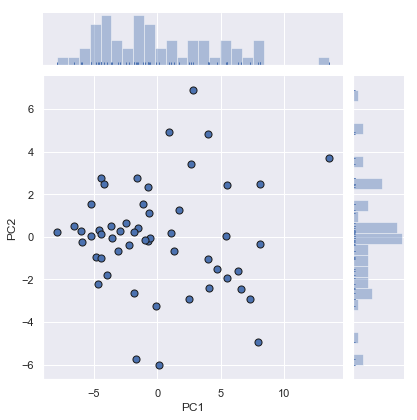

In [53]:
kmeans = K_means(1)
kmeans.main(data)
x=[];y=[]
for classification in kmeans.clusters:
    for features in kmeans.clusters[classification]:
        x.append(features[0]);y.append(features[1])
data = pd.DataFrame({
    'PC1': np.array(x),
    'PC2': np.array(y)})
h = sns.jointplot(x='PC1', y='PC2', data=data,\
                   marginal_kws=dict(bins=25, rug=True),\
                   s=50, edgecolor="k", linewidth=1)
#plt.savefig('C:\Users\IAN\Research\COSC 528\Project 2\Figures/PC2_jointplot.png',format='png',dpi=600)

##### Creating plots for Two PCs clustering using the created K_means class.

8-Clusters : Converged in 5 iterations


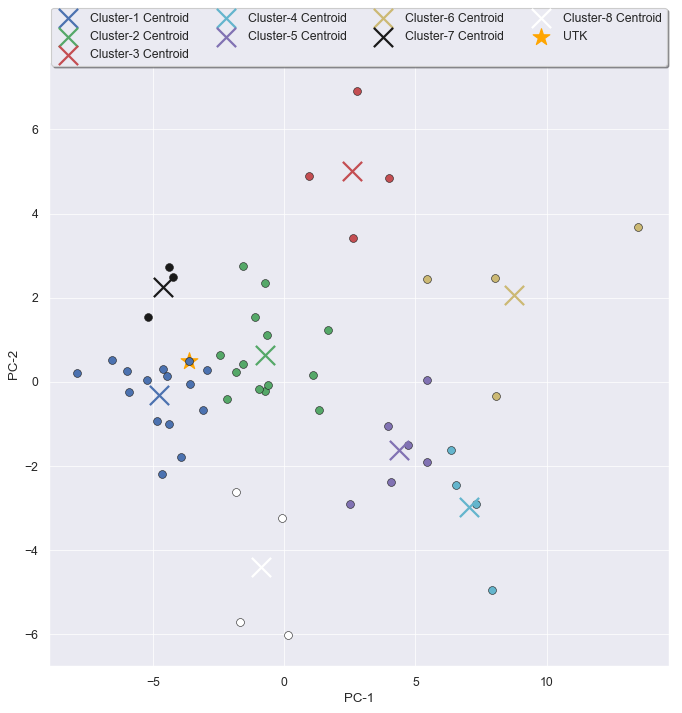

In [115]:
indexes = {}
data = getValues(2,a_standardized) # Only using first two PCs
for i in range(8,9):
    kmeans = K_means(i)
    kmeans.main(data)
    
    c = ['b','g','r','c','m','y','k','w'] # python default plot colors for clusters
    fig,ax = plt.subplots(figsize=(10,10),dpi=80) # figsize=(10,10) for savefig
    for classification in kmeans.clusters:
        color = c[classification]
        for features in kmeans.clusters[classification]:
            ax.scatter(features[0], features[1], color = color,s = 50,edgecolors='k',linewidth=0.5,zorder=3)

    for centroid in kmeans.centroids:
        legend_string = 'Cluster-%i Centroid'%(centroid+1)
        PC1 = kmeans.centroids[centroid][0]
        PC2 = kmeans.centroids[centroid][1]
        ax.scatter(PC1,PC2,s=300, marker="x",color=c[centroid],linewidth=2,label=legend_string,zorder=3)
    
    # Finding which Universities are with UTK
    if i >1:
        index = []
        for j in kmeans.clusters[0]:
            index.append(a_standardized.index[np.where(j[0] == data[:,0])[0][0]])
        indexes[i] = index
        
    ax.scatter(data[0][0],data[0][1],marker='*',s=250,color='orange',zorder=1,label='UTK')
    ax.grid(alpha=0.75)
    ax.set_axisbelow(True)
    ax.set_xlabel('PC-1');ax.set_ylabel('PC-2');
    if i <5:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.06),
          ncol=4, fancybox=True, shadow=True)        
    else:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=4, fancybox=True, shadow=True)
    #plt.savefig('/Users/i6o/Research/COSC 528/Project 2/Figures/'+'KMeans_Cluster_'+str(i)+'.png',format='png',dpi=600)
    plt.savefig('KMeans_9Clusters_15PC_'+str(i)+'.png',format='png',dpi=600)
    print '%i-Clusters : Converged in %i iterations'%(i,kmeans.centroids_converged)
    

In [116]:
# Printing names in clusters with UTK
indexes

{8: [u'Univ. of Tennessee - Knoxville',
  u'Auburn Univ.',
  u'Iowa State Univ.',
  u'Louisiana State Univ. ',
  u'Mississippi State Univ.',
  u'Univ. of Alabama ',
  u'Univ. of Arkansas -',
  u'Univ. of South Carolina ',
  u'Univ. of Oklahoma ',
  u'Univ. of Nebraska ',
  u'Colorado State',
  u'Univ. of Kansas ',
  u'U. of Massachusetts',
  u'Univ. of Oregon ',
  u'UC-Riverside']}

From the previous plots, the six cluster figure has a single-value cluster (Cluster-4) which is not ideal in most cases (on the contrary, in anomaly detection, outliers like that are important to quantify/cluster).

Elbow Method Calculation for Optimizing Number of Clusters for KMeans Algorithm.

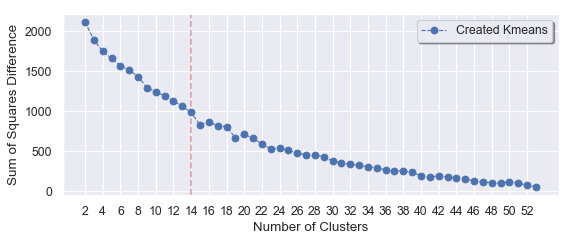

In [98]:
data = getValues(20,a_standardized) # Get first 20 PCs
n = len(data)
n_clusters = np.array(range(2,n))
ss_values = []; ss_sklearn=[]
for i in n_clusters:
    kmeans = K_means(i)
    kmeans.main(data)
    sq=0
    ss = {}
    for i in kmeans.centroids:
        sq1=0
        centroid = kmeans.centroids[i]
        cluster_data = kmeans.clusters[i]
        for j in cluster_data:
            value = (np.array(j)-np.array(centroid))**2
            sq1+=sum(value)
            ss[i]=sq1
    ss_values.append(sum(ss.values()))

fig,ax = plt.subplots(figsize=(8,3),dpi=80)
ax.plot(n_clusters,ss_values,'bo--',zorder=3,linewidth=1,label = 'Created Kmeans')
ax.set_xticks(n_clusters[::2])
ax.legend(loc='best',fancybox=True,shadow=True)
ax.set_ylabel('Sum of Squares Difference')
ax.set_xlabel('Number of Clusters')
ax.axvline(14,color='r',linestyle='--',alpha=0.5)
#plt.savefig('/Users/i6o/Research/COSC 528/Project 2/Figures/Elbow_plot.png',format='png',dpi=600)

Min. intercluster: 2.0000
Max. intracluster: 20.0000
Dunn index: 0.3301

Printing Min(inter) of first three
7.144766647255346 4.094967283482818 4.124811571546044
Printing Min(inter) of first three
17.862386639383285 12.937985816180303 11.203882867149007
Printing Dunn index of first three
0.39998947461491213 0.3165073251480639 0.36815911237705246


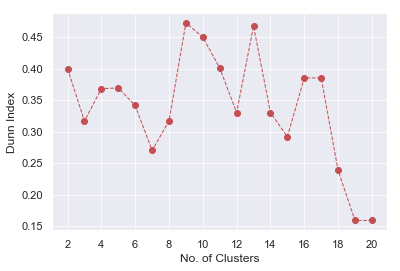

In [120]:
Dunn_index = {}; inter={};intra={}
data = getValues(2,a_standardized) # Get first 20 PCs
for i in range(2,21):
    kmeans = K_means(i)
    kmeans.main(data)
    
    c,inter[i] = intercluster_distance(kmeans.centroids)
    intra[i] = intracluster_distance(kmeans.clusters)
    Dunn_index[i] = min(inter[i])/max(intra[i])

fig,ax = plt.subplots();
ax.plot(Dunn_index.keys(),Dunn_index.values(),'ro--',linewidth=1)
ax.set_xticks(Dunn_index.keys()[::2])
ax.set_xlabel('No. of Clusters')
ax.set_ylabel('Dunn Index')
ax.grid(alpha=0.75)
ax.axes.set_axisbelow(True)
print 'Min. intercluster: %.4f'%min(inter)
print 'Max. intracluster: %.4f'%max(intra)
print 'Dunn index: %.4f'%Dunn_index[14]
print '\nPrinting Min(inter) of first three'
print min(inter[2]),min(inter[3]),min(inter[4])
print 'Printing Min(inter) of first three'
print max(intra[2]),max(intra[3]),max(intra[4])
print 'Printing Dunn index of first three'
print Dunn_index[2],Dunn_index[3],Dunn_index[4]


In [118]:
min(inter[8]),max(intra[8]),Dunn_index[8]

(2.578697528618103, 8.143685790440218, 0.31664992915679624)

In [121]:
class EM_Gmm:
    
    def __init__(self, n_clusters=3, max_iter=50,tol=0.001):
         self.n_clusters = n_clusters 
         self.max_iter = max_iter
         self.tol = tol

    def gaussian_func(self,data0, mean0, sigma0):
        '''
        Gaussiance function
        '''
        xmt = np.matrix(data0-mean0).transpose()
        for i in range(len(sigma0)):
            if sigma0[i,i] <= sys.float_info[3]:
                sigma0[i,i] = sys.float_info[3]
        sinv = np.linalg.inv(sigma0)
        xm = np.matrix(data0-mean0)
        return (2.0*np.pi)**(-len(data0)/2.0)*(1.0/np.sqrt(np.linalg.det(sigma0)))\
                *np.exp(-0.5*(xm*sinv*xmt))

    def makeParameters(self):
            mu0 = np.array([1.0*self.t[random.randint(0,self.uni_length-1),:]],np.float64)
            return {'mu': mu0,\
                    'sigma': np.matrix(np.diag([(self.min_max[f][1]-self.min_max[f][0])/2.0 for f in range(self.feature_length)])),\
                    'proba': 1.0/self.n_clusters}

    def main(self,data):
        self.t = data
        self.uni_length,self.feature_length = self.t.shape
        self.min_max = []
        # find ranges for each features
        for f in range(self.feature_length):
            self.min_max.append((self.t[:,f].min(), self.t[:,f].max()))

        self.min_max = []
        for f in range(self.feature_length):
            self.min_max.append((self.t[:,f].min(), self.t[:,f].max()))

        result = {}    # dictionary for cluster parameters
        distance = 0.0 # distance to centroid metric
        random.seed()  # creating random seed each call
        Pclust = np.ndarray([self.uni_length,self.n_clusters], np.float64) # P(cluster|uni)
        Px = np.ndarray([self.uni_length,self.n_clusters], np.float64)     # P(uni|cluster)

        for iteration in range(self.max_iter):
            # initialize
            parameters = [self.makeParameters() for c in range(self.n_clusters)]
            previous = sys.maxint
            log_estimate = sys.maxint/2 + self.tol 
            estimation_round = 0
            while (abs(log_estimate-previous) > self.tol\
                    and (log_estimate<previous)):
                converged = False # check parameter
                previous = log_estimate
                # Expectation Step: compute P(Cluster|Uni) for all universities
                for o in range(self.uni_length):
                    """
                    For each university (row), compute gaussian distance (prob) from created
                    clusters given by the mean (mu) and standard deviation (sigma). This results
                    in the probability that a university (o) is in the cluster (c).
                    """
                    for c in range(self.n_clusters):
                        Px[o,c] = self.gaussian_func(self.t[o,:],parameters[c]['mu'], parameters[c]['sigma'])

                for o in range(self.uni_length):
                    for c in range(self.n_clusters):
                        # Pclust[o,c] = P(cluster|uni)
                        '''
                        print 'Pcluster:%f'%Pclust[o,c]
                        print 'Px:%f'%Px[o,c]
                        print 'value:%s'%parameters[c]['proba']
                        '''
                        Pclust[o,c] = Px[o,c]*parameters[c]['proba']

                for o in range(self.uni_length):
                    tmpSum = 0.0
                    for c in range(self.n_clusters):
                        tmpSum += parameters[c]['proba']*Px[o,c]
                    Pclust[o,:] /= tmpSum

                # Update parameters in dictionary
                for c in range(self.n_clusters):
                    tmpSum = math.fsum(Pclust[:,c])
                    parameters[c]['proba'] = tmpSum/self.uni_length
                    if parameters[c]['proba'] <= 1.0/self.uni_length: 
                        converged = True                             
                        break
                    m = np.zeros(self.feature_length, np.float64)
                    for o in range(self.uni_length):
                        m += self.t[o,:]*Pclust[o,c]
                    parameters[c]['mu'] = m/tmpSum
                    s = np.matrix(np.diag(np.zeros(self.feature_length, np.float64)))
                    for o in range(self.uni_length):
                        s += Pclust[o,c]*(np.matrix(self.t[o,:]-parameters[c]['mu']).transpose()*np.matrix(self.t[o,:]-parameters[c]['mu']))

                # Test convergence; if not, force convergence
                if not converged:
                    converged = True
                    for c in range(1,self.n_clusters):
                        if not np.allclose(parameters[c]['mu'], parameters[c-1]['mu'])\
                        or not np.allclose(parameters[c]['sigma'], parameters[c-1]['sigma']):
                            converged = False
                            
                            break
                
                # Update parameters dictionary with converged values
                if converged:                
                    previous = sys.maxint
                    log_estimate = sys.maxint/2 + self.tol
                    parameters = [self.makeParameters() for c in range(self.n_clusters)]
                    
                    continue
                    
                estimation_round += 1

            # Find best results for parameter values based on distance
            distance = -log_estimate
            if not distance in result or distance > result['distance']:
                result['distance'] = distance
                result['parameters'] = copy.deepcopy(parameters)
                result['clusters'] = [[o for o in range(self.uni_length)\
                        if Px[o,c] == max(Px[o,:])]\
                        for c in range(self.n_clusters)]

        return result

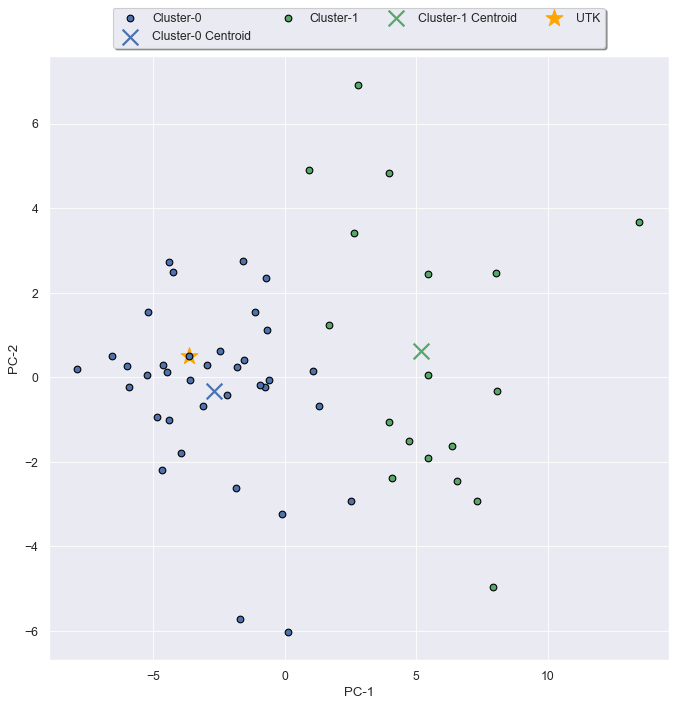

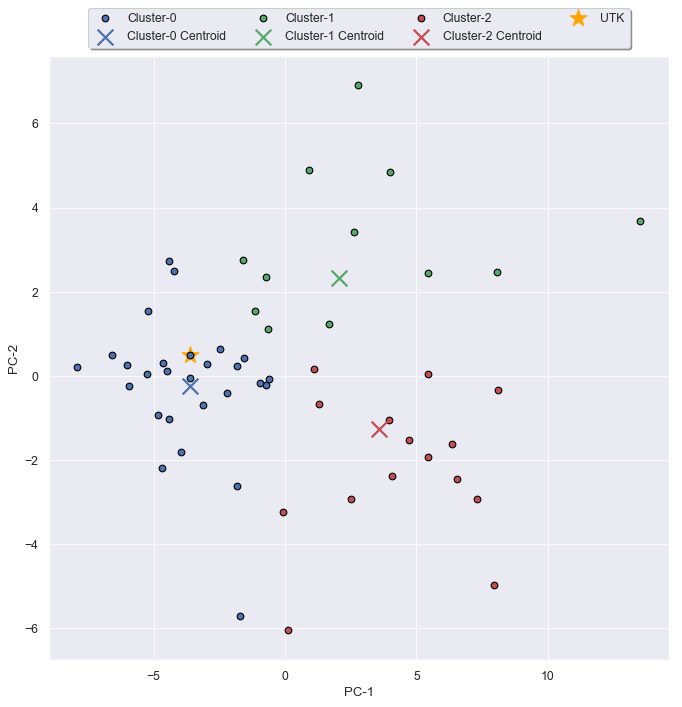

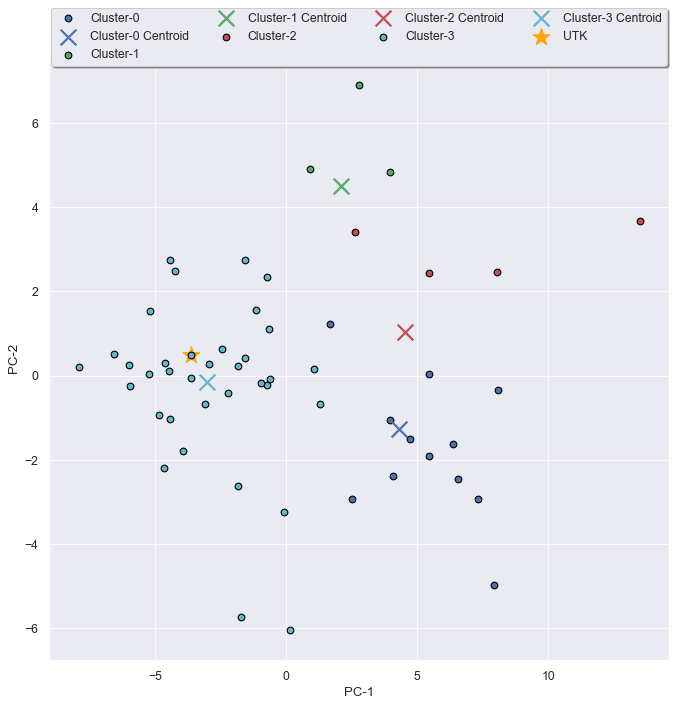

In [271]:
data = getValues(2,a_standardized) # Get first two PCs
colors = ['b','g','r','c']
for i in range(2,5):
    a = EM_Gmm(n_clusters=i) # initializing EM_Gmm
    results = a.main(data)   # calculating clusters for data (two PCs)
    fig,ax = plt.subplots(figsize=(10,10),dpi=80)
    for j in range(len(results['clusters'])):
        label = 'Cluster-%i'%j
        label_string = 'Cluster-%i Centroid'%j
        ax.scatter(data[results['clusters'][j]][:,0],data[results['clusters'][j]][:,1],\
                   color=colors[j],linewidth=1,edgecolor='black',label=label,zorder=2)
        ax.scatter(results['parameters'][j]['mu'][0],results['parameters'][j]['mu'][1],\
                   s=200, marker="x",color=colors[j],linewidth=2,label=label_string,zorder=2)
    ax.scatter(data[0][0],data[0][1],marker='*',s=250,color='orange',zorder=1,label='UTK')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.09),
          ncol=4, fancybox=True, shadow=True)
    ax.set_ylabel('PC-2')
    ax.set_xlabel('PC-1')
    ax.grid(linewidth=0.75)
    #plt.savefig('/Users/i6o/Research/COSC 528/Project 2/Figures/EM_Gmm_'+str(i)+'.png',format='png',dpi=600)


hello
